In [39]:
import importlib
importlib.reload(training)

<module 'training' from 'C:\\Users\\balda\\Desktop\\My Jyputer Nootebooks\\Projects\\Sampling\\training.py'>

In [ ]:
#<module 'training' from '../../../../secondary_funcs/training.py'>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from pathlib import Path
import sys
sys.path.append('../../../../secondary_funcs/')

#from data_preparation import get_final_data
from result_analysis import get_scores
import training
from result_analysis import predictions_to_classes

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from bayes_opt import BayesianOptimization

from wiseml.feature_engineering.wt_ohlc.wt_volatility import add_volatility

from wiseml.feature_engineering.ohlc import OHLCIndicatorsFeatureEngineer
from wiseml.validation.purged_k_fold import PurgedKFold

from wiseml.feature_engineering.wt_ohlc import add_volatility

# Data preparation

In [5]:
PATH_DATA = Path('../../../data/main_data/with_features/')

## Data loading

In [6]:
%%time
data = pd.read_csv('2019_tick100_tsfresh_ta_own_selected.csv')

Wall time: 35.6 s


In [7]:
data.shape

(2058595, 134)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2058595 entries, 0 to 2058594
Columns: 134 entries, datetime to others_cr
dtypes: float64(125), int64(8), object(1)
memory usage: 2.1+ GB


In [9]:
data.head()

,datetime,open,high,low,close,volume,month,day,weekday,is_weekend,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
0,2019-01-01 00:00:19.741071,3694.0,3694.0,3693.5,3694.0,96.157481,1,1,1,0,...,0.000000,-100.000000,0.010515,100.0,100.000000,-0.0,0.0,-56.277151,0.000000,0.000000
1,2019-01-01 00:00:19.741071,3694.0,3694.5,3694.0,3694.5,12.397309,1,1,1,0,...,11.421694,-99.992443,0.021028,100.0,100.000000,-0.0,0.0,0.013535,0.013535,0.013535
2,2019-01-01 00:00:47.543795,3694.5,3694.5,3694.0,3694.0,69.452628,1,1,1,0,...,6.965122,-99.989643,0.021025,50.0,83.333333,-50.0,0.0,-0.013534,-0.013535,0.000000
3,2019-01-01 00:01:07.336274,3694.0,3694.5,3693.0,3693.0,116.430367,1,1,1,0,...,4.211109,-99.988100,0.021019,0.0,50.000000,-100.0,0.0,-0.027071,-0.027075,-0.027071
4,2019-01-01 00:01:19.528369,3693.0,3693.0,3690.5,3690.5,49.689395,1,1,1,0,...,3.603404,-99.987087,0.021008,0.0,16.666667,-100.0,0.0,-0.067696,-0.067719,-0.094748


## Add some lags and returns

In [10]:
data['returns'] = data['close'].pct_change()
for i in range(1,31):
    data[f'lag_{i}'] = data['close'].shift(i)
    data[f'returns_{i}'] = data['close'].pct_change(i)
    data[f'returns_lag_{i}'] = data['returns_1'].shift(i)

In [11]:
%%time
data.dropna(axis=0, inplace=True)

Wall time: 7.8 s


In [12]:
data.shape

(2058564, 225)

## Labeling

In [13]:
from wiseml.data_preparation.labeling import add_tbm_label

In [14]:
%%time
data = add_tbm_label(data, 'close', [0.001, 0.0005], 10)

Wall time: 8.66 s


In [15]:
data.head()

,datetime,open,high,low,close,volume,month,day,weekday,is_weekend,...,lag_28,returns_28,returns_lag_28,lag_29,returns_29,returns_lag_29,lag_30,returns_30,returns_lag_30,target
31,2019-01-01 00:32:53.598027,3694.0,3694.0,3694.0,3694.0,2.373579,1,1,1,0,...,3693.0,0.000271,-0.000271,3694.0,0.000000,-0.000135,3694.5,-0.000135,0.000135,0
32,2019-01-01 00:32:54.144554,3694.0,3695.0,3692.0,3692.5,52.135906,1,1,1,0,...,3690.5,0.000542,-0.000677,3693.0,-0.000135,-0.000271,3694.0,-0.000406,-0.000135,1
33,2019-01-01 00:33:06.957635,3692.5,3694.0,3692.5,3694.0,93.988973,1,1,1,0,...,3690.5,0.000948,0.000000,3690.5,0.000948,-0.000677,3693.0,0.000271,-0.000271,0
34,2019-01-01 00:33:25.581504,3694.0,3694.0,3693.5,3693.5,88.978603,1,1,1,0,...,3690.5,0.000813,0.000000,3690.5,0.000813,0.000000,3690.5,0.000813,-0.000677,1
35,2019-01-01 00:33:48.820450,3693.5,3694.0,3693.5,3694.0,109.278507,1,1,1,0,...,3689.5,0.001220,-0.000271,3690.5,0.000948,0.000000,3690.5,0.000948,0.000000,0


# Selecting top features

In [16]:
from pickle import load

In [17]:
with open('features_names_albow_rule.pkl', 'rb') as f:
    columns = load(f)

In [18]:
top_feat = columns[:-1]
top_feat.append('target')

In [19]:
data = data[top_feat]

In [20]:
data.drop(columns=['close_returns', 'returns'], axis=1, inplace=True)

In [35]:
df_part_1 = data.iloc[1029277:2058554]
# df_part_2 = data.iloc[411711:823422]
# df_part_3 = data.iloc[823422:1235133]
# df_part_4 = data.iloc[1235133:1646844]
# df_part_5 = data.iloc[1646844:2058550]

In [36]:
len(data)

2058554

In [38]:
df_part_1.to_csv('data_for_test.csv')

## Split data to train and test sets

In [22]:
data_train = data[data['datetime'] < '2019-09-14']
data_test = data[data['datetime'] >= '2019-09-14']

del data

In [23]:
data_train.head()

,volatility_atr,volume_adi,momentum_tsi,momentum_rsi,momentum_stoch,momentum_wr,returns_lag_1,minute,"value__fft_coefficient__coeff_0__attr_""abs""",close_returns_log,...,"value__fft_coefficient__coeff_2__attr_""angle""","value__fft_coefficient__coeff_8__attr_""abs""",value__number_crossing_m__m_0,value__c3__lag_2,"value__fft_aggregated__aggtype_""variance""",returns_25,returns_16,returns_26,datetime,target
31,1.182782,78.949368,-99.764196,84.631717,100.000000,-0.000000,0.000271,32,1.960533e-08,0.000000,...,43.703576,0.000165,5.0,1.921085e-15,19.320661,0.000948,0.001355,0.000948,2019-01-01 00:32:53.598027,0
32,1.312583,-34.757271,-99.738620,66.290519,72.222222,-27.777778,0.000000,32,1.960533e-08,-0.000049,...,56.473447,0.000143,6.0,1.854841e-15,20.101303,0.000813,0.000949,0.000542,2019-01-01 00:32:54.144554,1
33,1.325970,59.231702,-99.708268,73.033688,88.888889,-11.111111,-0.000406,33,4.946487e-05,0.000049,...,74.088318,0.000136,6.0,-8.949248e-16,23.313741,0.001491,0.001355,0.001220,2019-01-01 00:33:06.957635,0
34,1.266972,5.010369,-99.678749,67.816082,83.333333,-16.666667,0.000406,33,2.205004e-08,-0.000016,...,77.700866,0.000055,7.0,-8.660563e-16,24.387414,0.001491,0.001220,0.001356,2019-01-01 00:33:25.581504,1
35,1.212188,20.299904,-99.648044,70.267031,88.888889,-11.111111,-0.000135,33,1.650103e-05,0.000016,...,90.501151,0.000125,8.0,2.510254e-19,30.303887,0.002170,0.001763,0.001627,2019-01-01 00:33:48.820450,0


In [24]:
data_test.head()

,volatility_atr,volume_adi,momentum_tsi,momentum_rsi,momentum_stoch,momentum_wr,returns_lag_1,minute,"value__fft_coefficient__coeff_0__attr_""abs""",close_returns_log,...,"value__fft_coefficient__coeff_2__attr_""angle""","value__fft_coefficient__coeff_8__attr_""abs""",value__number_crossing_m__m_0,value__c3__lag_2,"value__fft_aggregated__aggtype_""variance""",returns_25,returns_16,returns_26,datetime,target
1658740,2.040029,56.431346,-8.504368,55.309074,48.780488,-51.219512,0.000048,0,0.000057,0.000005,...,-139.423972,0.000059,21.0,-1.205408e-15,190.684531,-0.001156,-0.001300,-0.001252,2019-09-14 00:00:02.954793,1
1658741,1.965742,9.838215,-8.169932,58.834449,66.666667,-33.333333,0.000048,0,0.000042,0.000010,...,-130.172193,0.000067,21.0,-1.196536e-15,192.073777,-0.000723,-0.001156,-0.001060,2019-09-14 00:00:03.550895,1
1658742,1.861046,5.947647,-7.772856,60.626332,79.310345,-20.689655,0.000096,0,0.000021,0.000005,...,-119.603050,0.000073,21.0,-1.166978e-15,191.604731,-0.000289,-0.000867,-0.000674,2019-09-14 00:00:04.382823,1
1658743,1.799542,4.493662,-7.218878,64.220421,100.000000,-0.000000,0.000048,0,0.000005,0.000010,...,-107.387616,0.000075,21.0,-1.158115e-15,191.839079,-0.000241,-0.000385,-0.000193,2019-09-14 00:00:07.985610,1
1658744,1.813861,8.027678,-6.525784,67.629807,96.428571,-3.571429,0.000096,0,0.000021,0.000010,...,-96.832168,0.000073,21.0,-1.152209e-15,190.378123,-0.000193,-0.000048,-0.000145,2019-09-14 00:00:09.141629,1


In [25]:
col_tmp = data_train.columns.values.tolist()

In [26]:
clmn = []
for column in col_tmp:
    if column.find('retur') > -1:
        clmn.append(column)

In [27]:
sorted(clmn)

['close_returns_log',
 'returns_1',
 'returns_10',
 'returns_11',
 'returns_12',
 'returns_13',
 'returns_15',
 'returns_16',
 'returns_2',
 'returns_21',
 'returns_23',
 'returns_25',
 'returns_26',
 'returns_28',
 'returns_29',
 'returns_3',
 'returns_30',
 'returns_4',
 'returns_5',
 'returns_6',
 'returns_7',
 'returns_8',
 'returns_9',
 'returns_lag_1',
 'returns_lag_2']

## Target distribution

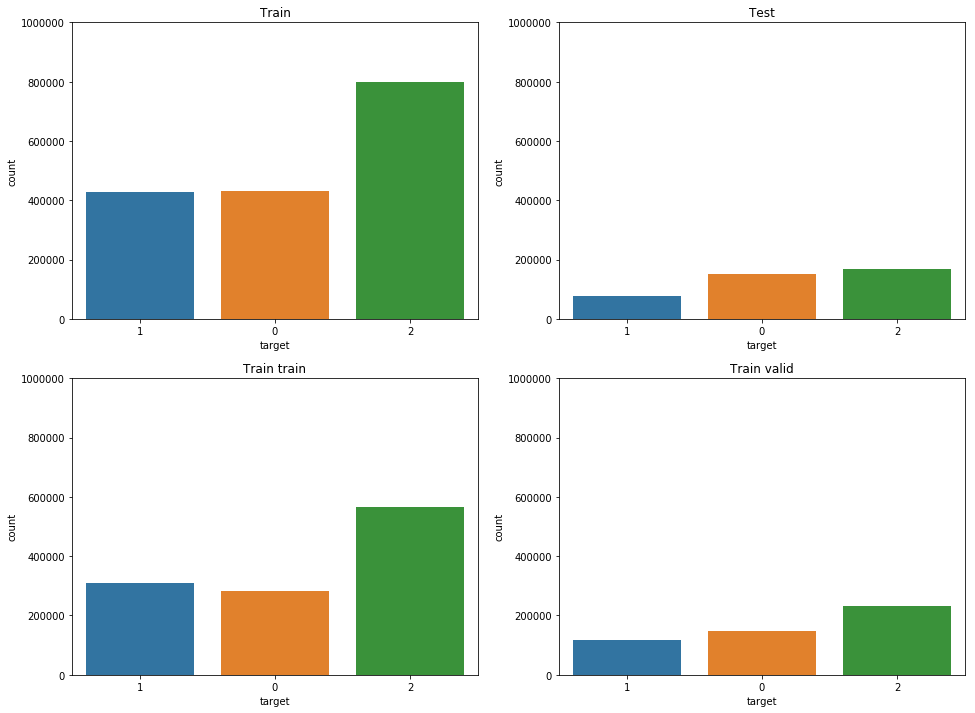

In [28]:
plt.figure(figsize=(16, 12))
y_max = 1000000

plt.subplot(221)
plt.title('Train')
plt.ylim([0,y_max])
sns.countplot(data_train['target'], order=[1, 0, 2]);

plt.subplot(222)
plt.title('Test')
plt.ylim([0,y_max])
sns.countplot(data_test['target'], order=[1, 0, 2]);

plt.subplot(223)
plt.title('Train train')
plt.ylim([0,y_max])
sns.countplot(data_train['target'].iloc[:int(data_train.shape[0] * 0.7)], order=[1, 0, 2]);

plt.subplot(224)
plt.title('Train valid')
plt.ylim([0,y_max])
sns.countplot(data_train['target'].iloc[int(data_train.shape[0] * 0.7):], order=[1, 0, 2]);

In [29]:
data_test['target'].value_counts(normalize=True)

2    0.424797
0    0.381253
1    0.193950
Name: target, dtype: float64

### Preparing train and test dataframes

In [30]:
X = data_train.drop(['target', 'datetime'], axis=1)
y = data_train['target']

X_test = data_test.drop(['target', 'datetime'], axis=1)
y_test = data_test['target']

del data_train
del data_test

# Funcs

## Evaluation func (for hyperparameters)

In [46]:
def lgb_train(max_depth,
             feature_fraction,
             bagging_fraction,
             lambda_l1,
             lambda_l2,
             num_leaves,
             min_child_samples,
             min_gain_to_split
            ):

    model_params = {'max_depth': int(max_depth),
                    'feature_fraction': feature_fraction,
                    'bagging_fraction': bagging_fraction,
                    'lambda_l1': lambda_l1,
                    'lambda_l2': lambda_l2,
                    'num_leaves': int(num_leaves),                
                    'min_child_samples': int(min_child_samples),
                    'min_gain_to_split': min_gain_to_split
                   }
    
    optim_params = {'num_boost_round': 10000,
                    'learning_rate': 0.01,
                    'early_stopping_rounds': 300,
                    'verbose_eval': 100
                   }


    task_params = {'objective': 'multiclass',
                   'num_class': 3,
                   'metric': 'multi_logloss'
                  }

    device_params = {'device': 'cpu',
#                      'gpu_platform_id': 0,
#                      'gpu_device_id': 0,
#                      'max_bin': 255,
                     'num_threads': 4
                    }

    
    return training.lgb_train(X_res, pd.Series(y_res), optim_params=optim_params, model_params=model_params, task_params=task_params, device_params=device_params)

In [47]:
def lgb_eval(max_depth,
             feature_fraction,
             bagging_fraction,
             lambda_l1,
             lambda_l2,
             num_leaves,
             min_child_samples,
             min_gain_to_split
            ):

    model_params = {'max_depth': int(max_depth),
                    'feature_fraction': feature_fraction,
                    'bagging_fraction': bagging_fraction,
                    'lambda_l1': lambda_l1,
                    'lambda_l2': lambda_l2,
                    'num_leaves': int(num_leaves),                
                    'min_child_samples': int(min_child_samples),
                    'min_gain_to_split': min_gain_to_split
                   }
    

    optim_params = {'num_boost_round': 200,
                    'learning_rate': 0.03,
                    'early_stopping_rounds': 50,
                    'verbose_eval': 0
                   }

    task_params = {'objective': 'multiclass',
                   'num_class': 3,
                   'metric': 'multi_logloss'
                  }

    device_params = {'device': 'cpu',
#                      'gpu_platform_id': 0,
#                      'gpu_device_id': 0,
#                      'max_bin': 63,
                     'num_threads': 4
                    }

    
    return training.lgb_train(X, pd.Series(y), optim_params=optim_params, model_params=model_params, task_params=task_params, device_params=device_params, tuning=True)

## Hyperparam tuning func (Bayesian opt)

In [52]:
def param_tuning(init_points, num_iter, **args):
    
    lgbBO = BayesianOptimization(lgb_eval, {'max_depth': (4, 6),
                                            'feature_fraction': (0.7, 1),
                                            'bagging_fraction': (0.7, 1),
                                            'lambda_l1': (0.0, 0.1),
                                            'lambda_l2': (0.0, 0.1),
                                            'num_leaves': (23, 25),
                                            'min_child_samples': (10, 100),
                                            'min_gain_to_split': (0, 0),
                                            })
    
    lgbBO.maximize(init_points=init_points, n_iter=num_iter, **args)
    return lgbBO

# Hyperparam tuning

In [53]:
X.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X.columns]

In [54]:
X_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]

In [55]:
%%time
bayesian_tun = param_tuning(3, 5)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_ga... | num_le... |
-------------------------------------------------------------------------------------------------------------------------


MemoryError: 

In [103]:
# #!https_proxy=https://141.125.82.106:80 telegram-send 'Bayesian optimization for LONG: done.'
params = bayesian_tun.max['params']

In [104]:
params

# Training

## Oversampling

In [40]:
# from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import ADASYN
# from imblearn.over_sampling import BorderlineSMOTE
# from imblearn.over_sampling import KMeansSMOTE
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.over_sampling import SVMSMOTE

In [105]:
from kmeans_smote import KMeansSMOTE

In [117]:
#sm = SMOTE(k_neighbors=5, n_jobs=-1)
#sm = ADASYN(random_state=0, n_neighbors=5)
#sm = BorderlineSMOTE(random_state=0, k_neighbors=5, n_jobs=-1)
#sm = KMeansSMOTE(random_state=0)
#sm = RandomOverSampler(random_state=0)
#sm = SVMSMOTE(random_state=0, k_neighbors=5, n_jobs=-1)

In [118]:
kmeans_smote = KMeansSMOTE(
    kmeans_args={'n_clusters': 100},
    smote_args={'k_neighbors': 10})

In [107]:
point = int(len(X) * 0.7)

In [53]:
# %%time
# X_res_1, y_res_1 = sm.fit_resample(X.iloc[:point, :], y[:point])

Wall time: 10min 54s


In [108]:
%%time
X_res_1, y_res_1 = kmeans_smote.fit_resample(X.iloc[:point, :], y[:point])

C:\Users\balda\AppData\Roaming\Python\Python37\site-packages\kmeans_smote.py:213: RuntimeWarning: overflow encountered in double_scalars
  density_factor = minority_count / (average_minority_distance ** self.density_power)
C:\Users\balda\AppData\Roaming\Python\Python37\site-packages\kmeans_smote.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  sparsity_factors[i] = 1 / density_factor
C:\Users\balda\AppData\Roaming\Python\Python37\site-packages\kmeans_smote.py:213: RuntimeWarning: overflow encountered in double_scalars
  density_factor = minority_count / (average_minority_distance ** self.density_power)
C:\Users\balda\AppData\Roaming\Python\Python37\site-packages\kmeans_smote.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  sparsity_factors[i] = 1 / density_factor
C:\Users\balda\AppData\Roaming\Python\Python37\site-packages\kmeans_smote.py:213: RuntimeWarning: overflow encountered in double_scalars
  density_factor = minority_count / (average_

Wall time: 6min 15s


In [109]:
X_res = pd.DataFrame(X_res_1, columns=X.columns)

In [110]:
X_res = X_res.append(X.iloc[point:, :])
y_res = pd.Series(y_res_1).append(y[point:])

In [111]:
len(X_res_1) / len(X_res) 

0.7733253343318419

In [115]:
X_res_1.shape

(1697661, 123)

In [116]:
X_res.shape

(2195274, 123)

In [57]:
# 0.7733253343318419
# 0.7739342454775537
# 0.7733253343318419
#
#
#

In [58]:
del X_res_1
del y_res_1
del X
del y

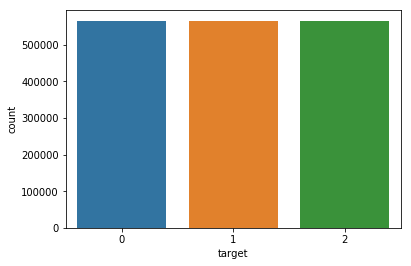

In [59]:
sns.countplot(y_res[:int(len(y_res) * 0.7733)]);

In [60]:
y_res.value_counts()

2    798342
0    714080
1    682852
Name: target, dtype: int64

In [57]:
(y_res.value_counts()[2]/len(y_res))*100

36.36639435441772

In [ ]:
#SMOTE
#     0 - 32.5
#     1 - 31.1
#     2 - 36.3

#ADASYN
#     0 - 32.1
#     0 - 31.5
#     0 - 36.2

#BorderlineSMOTE
#     0 - 32.5
#     1 - 31.1
#     2 - 36.3



In [52]:
params = {'bagging_fraction': 0.612597911312686,
 'feature_fraction': 0.5623226633160302,
 'lambda_l1': 0.00047107687613179294,
 'lambda_l2': 0.01359749662288301,
 'max_depth': 14.220787633196979,
 'min_child_samples': 1103.1080006183051,
 'min_gain_to_split': 0.0,
 'num_leaves': 12550.527293636744}

In [53]:
params

{'bagging_fraction': 0.612597911312686,
 'feature_fraction': 0.5623226633160302,
 'lambda_l1': 0.00047107687613179294,
 'lambda_l2': 0.01359749662288301,
 'max_depth': 14.220787633196979,
 'min_child_samples': 1103.1080006183051,
 'min_gain_to_split': 0.0,
 'num_leaves': 12550.527293636744}

In [54]:
params_my = params
params_my['feature_fraction'] = 1
#params_my['num_leaves'] = 17000
#params_my['min_child_samples'] = 280

In [58]:
%%time
model = lgb_train(**params)

Training until validation scores don't improve for 300 rounds.
[100]	train's multi_logloss: 0.915793	valid's multi_logloss: 1.00105
[200]	train's multi_logloss: 0.843229	valid's multi_logloss: 0.96849
[300]	train's multi_logloss: 0.801843	valid's multi_logloss: 0.950728
[400]	train's multi_logloss: 0.77655	valid's multi_logloss: 0.939769
[500]	train's multi_logloss: 0.756242	valid's multi_logloss: 0.931692
[600]	train's multi_logloss: 0.737956	valid's multi_logloss: 0.920289
[700]	train's multi_logloss: 0.724651	valid's multi_logloss: 0.913052
[800]	train's multi_logloss: 0.712483	valid's multi_logloss: 0.909009
[900]	train's multi_logloss: 0.702189	valid's multi_logloss: 0.906516
[1000]	train's multi_logloss: 0.693512	valid's multi_logloss: 0.904487
[1100]	train's multi_logloss: 0.685173	valid's multi_logloss: 0.903134
[1200]	train's multi_logloss: 0.677744	valid's multi_logloss: 0.902497
[1300]	train's multi_logloss: 0.670796	valid's multi_logloss: 0.901656
[1400]	train's multi_loglo

KeyboardInterrupt: 

In [ ]:
# [100]	train's multi_logloss: 0.915793	valid's multi_logloss: 1.00105
# [200]	train's multi_logloss: 0.843229	valid's multi_logloss: 0.96849
# [300]	train's multi_logloss: 0.801843	valid's multi_logloss: 0.950728
# [400]	train's multi_logloss: 0.77655	valid's multi_logloss: 0.939769
# [500]	train's multi_logloss: 0.756242	valid's multi_logloss: 0.931692
# [600]	train's multi_logloss: 0.737956	valid's multi_logloss: 0.920289
# [700]	train's multi_logloss: 0.724651	valid's multi_logloss: 0.913052
# [800]	train's multi_logloss: 0.712483	valid's multi_logloss: 0.909009
# [900]	train's multi_logloss: 0.702189	valid's multi_logloss: 0.906516
# [1000]	train's multi_logloss: 0.693512	valid's multi_logloss: 0.904487
# [1100]	train's multi_logloss: 0.685173	valid's multi_logloss: 0.903134
# [1200]	train's multi_logloss: 0.677744	valid's multi_logloss: 0.902497
# [1300]	train's multi_logloss: 0.670796	valid's multi_logloss: 0.901656
# [1400]	train's multi_logloss: 0.664157	valid's multi_logloss: 0.901654
# [1500]	train's multi_logloss: 0.658417	valid's multi_logloss: 0.901171
# [1600]	train's multi_logloss: 0.6532	valid's multi_logloss: 0.900582
# [1700]	train's multi_logloss: 0.647847	valid's multi_logloss: 0.899969
# [1800]	train's multi_logloss: 0.642638	valid's multi_logloss: 0.899138
# [1900]	train's multi_logloss: 0.637511	valid's multi_logloss: 0.898411
# [2000]	train's multi_logloss: 0.632355	valid's multi_logloss: 0.89751

In [85]:
model.save_model('../../../models/LONG_10.01.20_selected_feat_tick100.txt')

NameError: name 'model' is not defined

## Checking results

### On full test dataset

**All features result** \
Test data part = 199923 / 199923 = 100.0% \
Accuracy = 0.5715 \
Precision = 0.5643 \
Recall = 0.5715
___
**Real classes where 0 was predicted:** \
0    63.341281 \
2    25.887800 \
1    10.770919 \
Name: y, dtype: float64 \
0    50210 \
2    20521 \
1     8538 \
Name: y, dtype: int64

**Real classes where 1 was predicted:** \
1    47.555919 \
2    36.158583 \
0    16.285499 \
Name: y, dtype: float64 \
1    7569 \
2    5755 \
0    2592 \
Name: y, dtype: int64

**Real classes where 2 was predicted:** \
2    53.925032 \
0    25.009070 \
1    21.065898 \
Name: y, dtype: float64 \
2    56480 \
0    26194 \
1    22064 \
Name: y, dtype: int64

In [69]:
prediction = model.predict(X_test, num_iteration=model.best_iteration)

In [79]:
pred_power, y_power, part, acc, pre, rec, idx = get_scores(prediction, list(y_test), min_confidence=0.54)
print(f"""
Test data part = {part}
Accuracy = {acc}
Precision = {pre}
Recall = {rec}
""")


Test data part = 181512 / 399845 = 45.4%
Accuracy = 0.6664
Precision = 0.6536
Recall = 0.6664



In [73]:
pd.Series(y_power).value_counts(normalize=True)

2    0.44182
0    0.38564
1    0.17254
dtype: float64

In [80]:
res_df = pd.DataFrame({'pred': pred_power, 'y': y_power})
print('Real classes where 0 was predicted:')
res_df[res_df['pred'] == 0]['y'].value_counts(normalize=True) * 100
res_df[res_df['pred'] == 0]['y'].value_counts()
print('\nReal classes where 1 was predicted:')
res_df[res_df['pred'] == 1]['y'].value_counts(normalize=True) * 100
res_df[res_df['pred'] == 1]['y'].value_counts()
print('\nReal classes where 2 was predicted:')
res_df[res_df['pred'] == 2]['y'].value_counts(normalize=True) * 100
res_df[res_df['pred'] == 2]['y'].value_counts()

Real classes where 0 was predicted:


0    70.482310
2    21.910063
1     7.607626
Name: y, dtype: float64

0    56598
2    17594
1     6109
Name: y, dtype: int64


Real classes where 1 was predicted:


1    54.462872
2    37.828152
0     7.708976
Name: y, dtype: float64

1    6535
2    4539
0     925
Name: y, dtype: int64


Real classes where 2 was predicted:


2    64.809667
1    19.189123
0    16.001211
Name: y, dtype: float64

2    57818
1    17119
0    14275
Name: y, dtype: int64

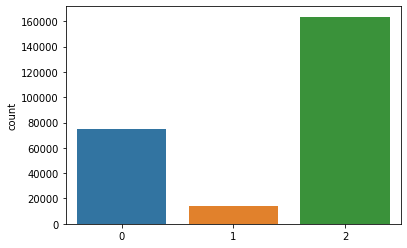

In [57]:
sns.countplot(pred_power)

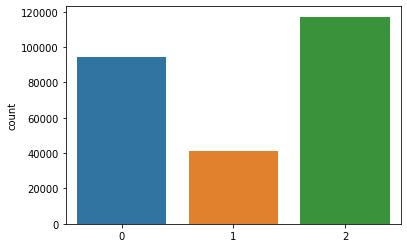

In [58]:
sns.countplot(y_power)

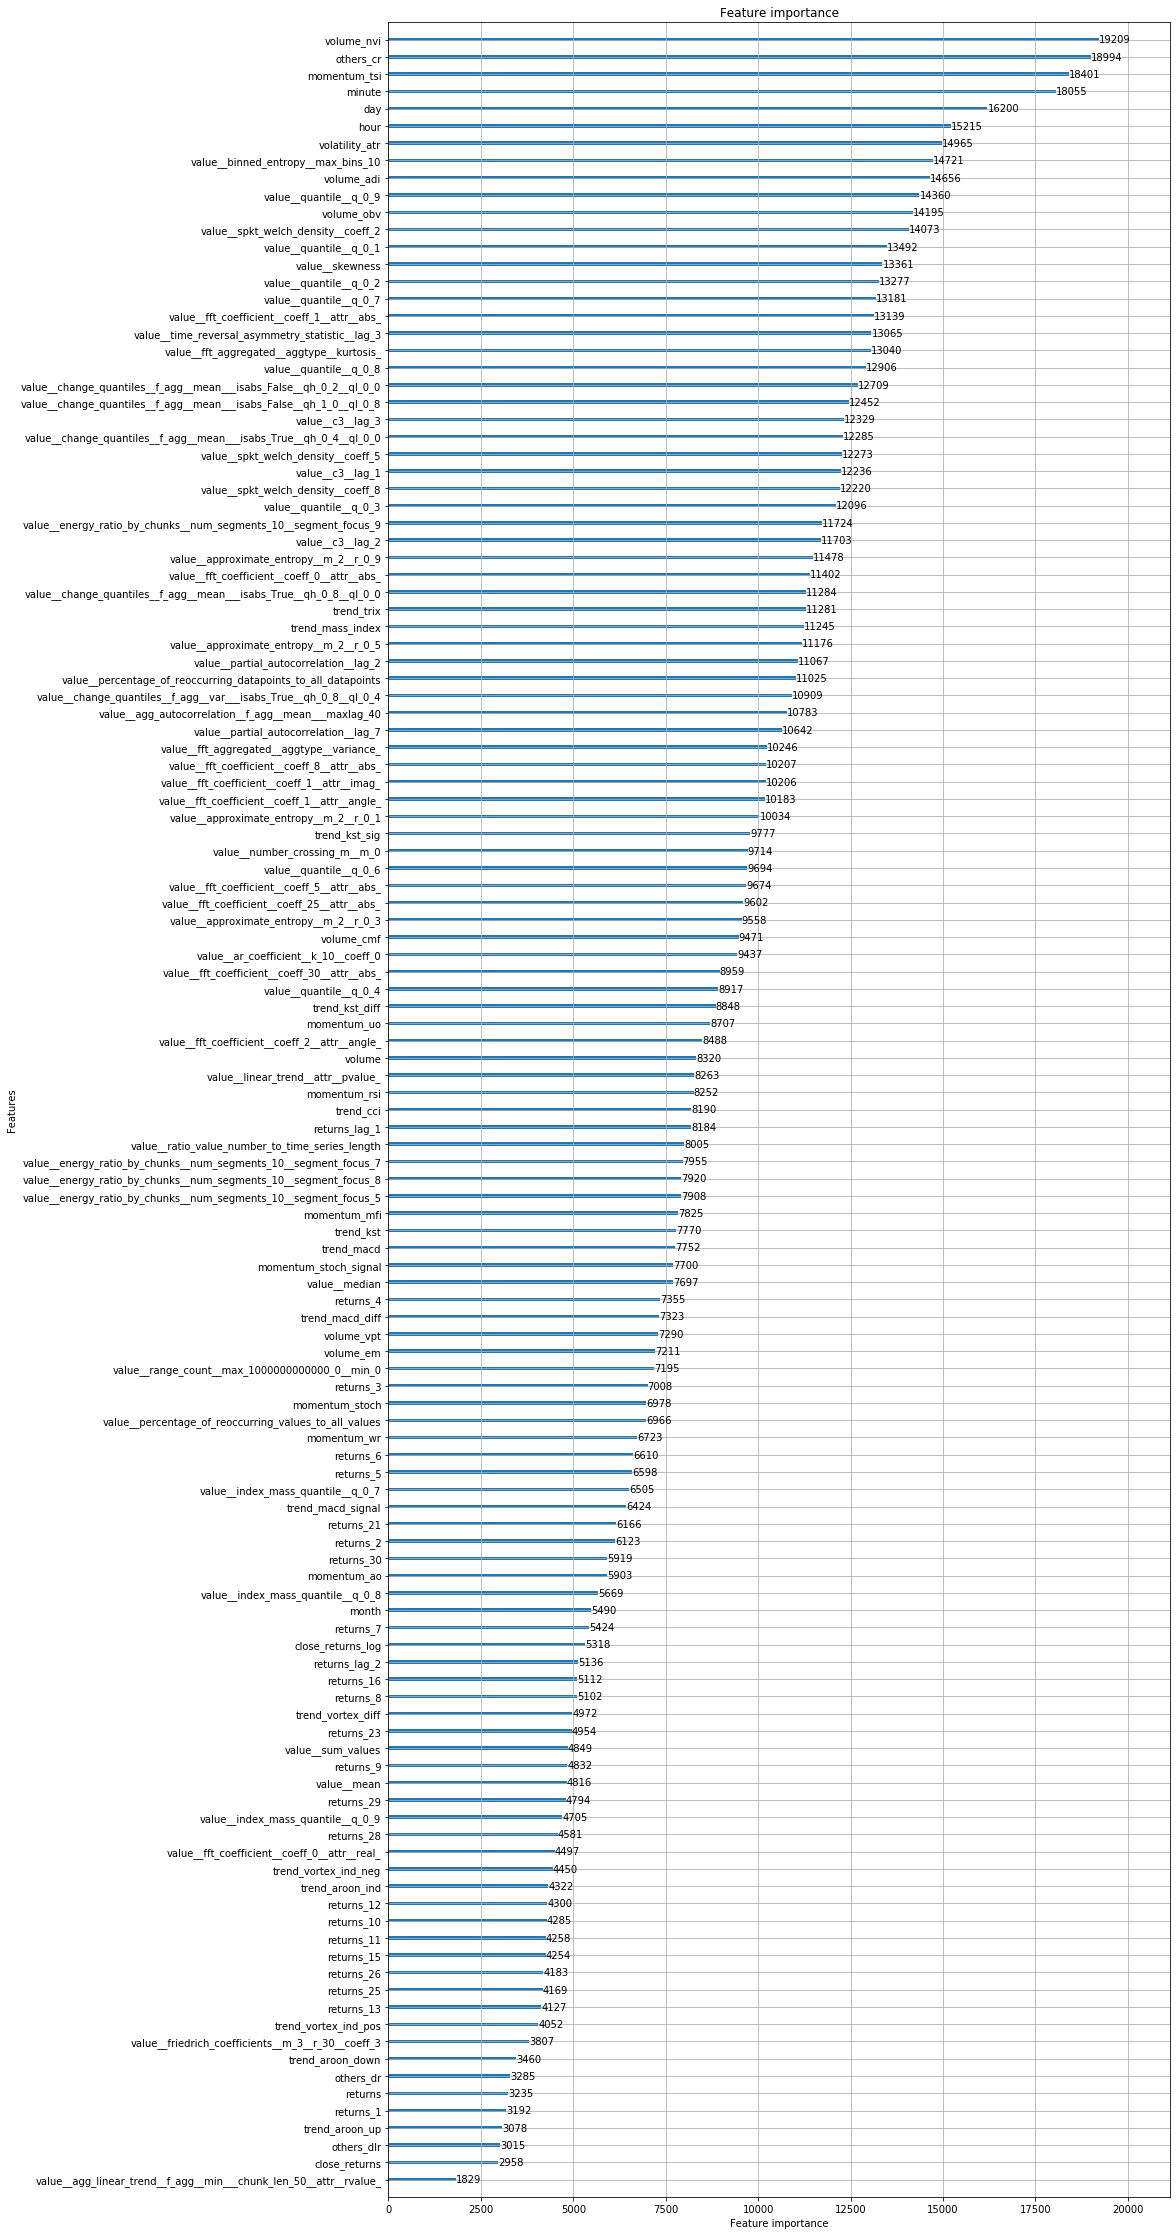

In [54]:
lgb.plot_importance(model, figsize=(14,40), importance_type='split')